This notebook contains solving the classification problem for the Severity of collisions Data for IBM capstone course.

In [653]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore") 
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
# from matplotlib import ticker 
%matplotlib inline
from sklearn.svm import SVC
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

### Reading data

In [654]:
df=pd.read_csv('E:\IBM capstone course\Data-Collisions.csv',dtype={'SPEEDING':object})
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


### Choosing features that will be used in the problem

In [655]:
df=df[['SEVERITYCODE','ADDRTYPE','COLLISIONTYPE','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT','INATTENTIONIND',
       'UNDERINFL','WEATHER','ROADCOND','LIGHTCOND','PEDROWNOTGRNT','SPEEDING','HITPARKEDCAR']]

### Checking data types for each column and missing values

In [656]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   SEVERITYCODE    194673 non-null  int64 
 1   ADDRTYPE        192747 non-null  object
 2   COLLISIONTYPE   189769 non-null  object
 3   PERSONCOUNT     194673 non-null  int64 
 4   PEDCOUNT        194673 non-null  int64 
 5   PEDCYLCOUNT     194673 non-null  int64 
 6   VEHCOUNT        194673 non-null  int64 
 7   INATTENTIONIND  29805 non-null   object
 8   UNDERINFL       189789 non-null  object
 9   WEATHER         189592 non-null  object
 10  ROADCOND        189661 non-null  object
 11  LIGHTCOND       189503 non-null  object
 12  PEDROWNOTGRNT   4667 non-null    object
 13  SPEEDING        9333 non-null    object
 14  HITPARKEDCAR    194673 non-null  object
dtypes: int64(5), object(10)
memory usage: 22.3+ MB


In [657]:
for col in df.columns:
    print(col)
    print(df[col].value_counts())
    print('\n')
    

SEVERITYCODE
1    136485
2     58188
Name: SEVERITYCODE, dtype: int64


ADDRTYPE
Block           126926
Intersection     65070
Alley              751
Name: ADDRTYPE, dtype: int64


COLLISIONTYPE
Parked Car    47987
Angles        34674
Rear Ended    34090
Other         23703
Sideswipe     18609
Left Turn     13703
Pedestrian     6608
Cycles         5415
Right Turn     2956
Head On        2024
Name: COLLISIONTYPE, dtype: int64


PERSONCOUNT
2     114231
3      35553
4      14660
1      13154
5       6584
0       5544
6       2702
7       1131
8        533
9        216
10       128
11        56
12        33
13        21
14        19
15        11
17        11
16         8
44         6
18         6
20         6
25         6
19         5
26         4
22         4
27         3
28         3
29         3
47         3
32         3
34         3
37         3
23         2
21         2
24         2
30         2
36         2
57         1
31         1
35         1
39         1
41         1
43         

### Exploratory data analysis (EDA)

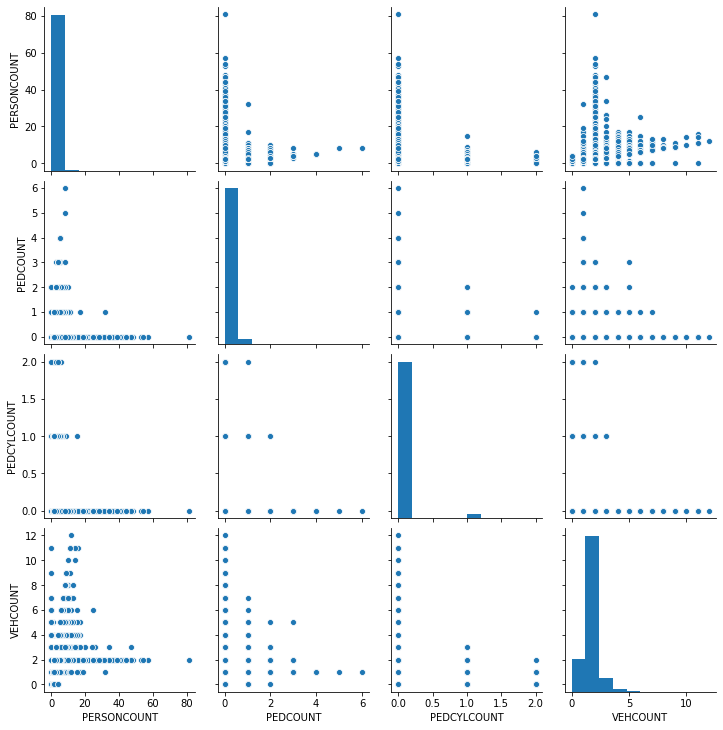

In [658]:
sns.pairplot(df[['PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT']])

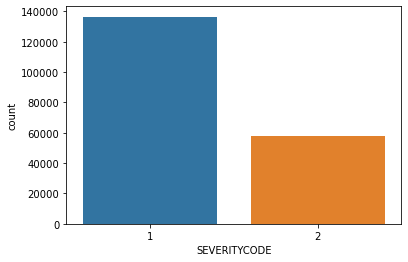

In [659]:
sns.countplot(df['SEVERITYCODE'])

The majority of the data had accident severity with proper damage (1), while the minority lead to injury (2)

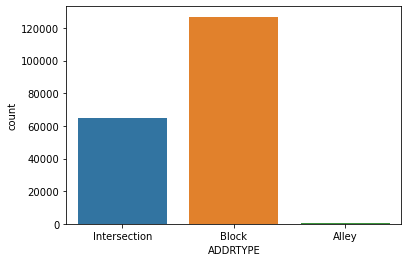

In [660]:
sns.countplot(df['ADDRTYPE'])

The majority collision address type is "Block" then "Intersection" while minimum in "Alley"

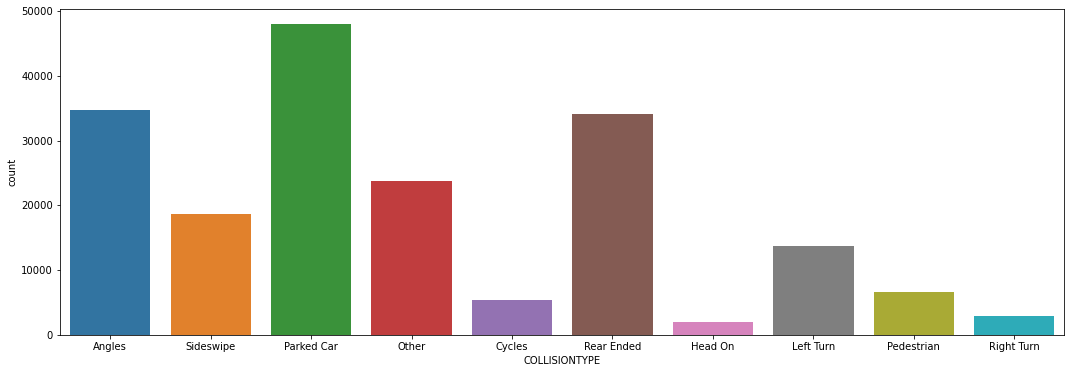

In [661]:
plt.figure(figsize=(18,6))
sns.countplot(df['COLLISIONTYPE'])

There are nine collision types in the dataset. The three majority collision types are: "Parked Car", "Rear Ended" and "Angles"

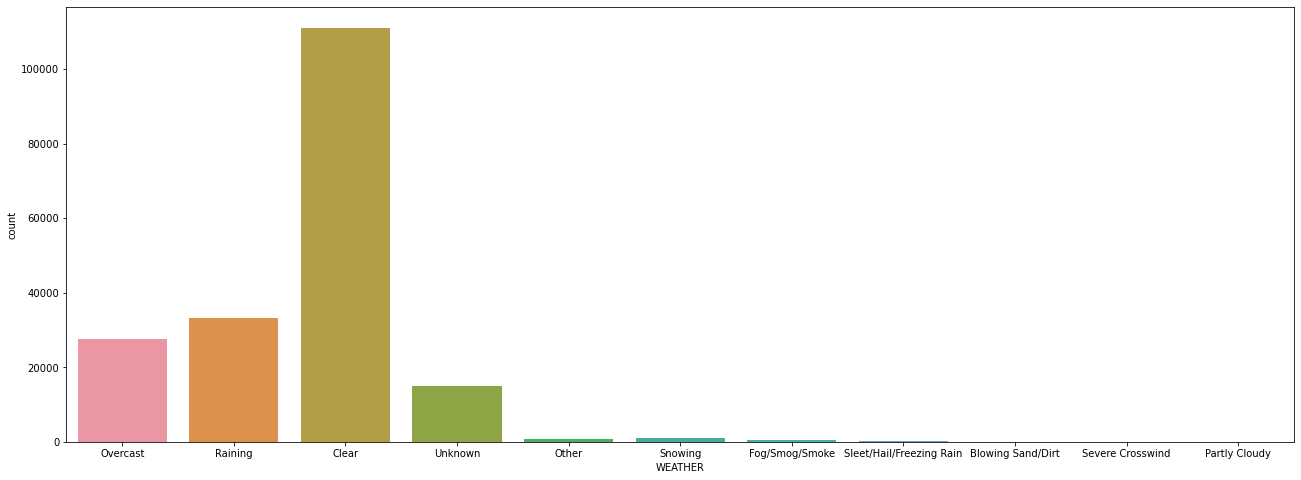

In [663]:
plt.figure(figsize=(22,8))
sns.countplot(df['WEATHER'])

There are nine different weather conditions in the dataset. The majority three weather conditions are: "Clear", "Raining" and "Overcast"

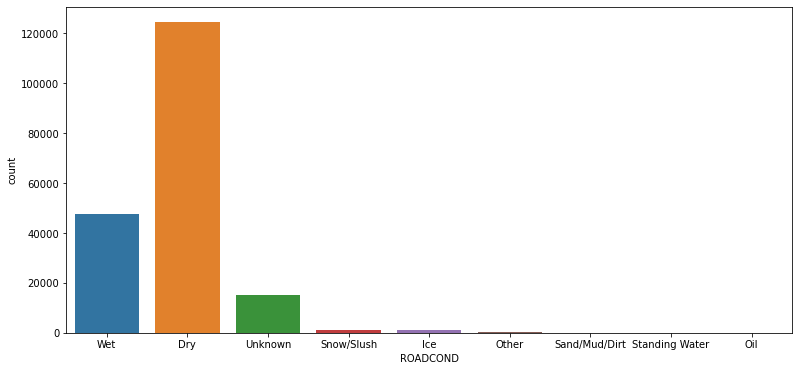

In [666]:
plt.figure(figsize=(13,6))

sns.countplot(df['ROADCOND'])

There are seven road conditions in the dataset. The majority conditions are the "Dry" and "Wet" road conditions.

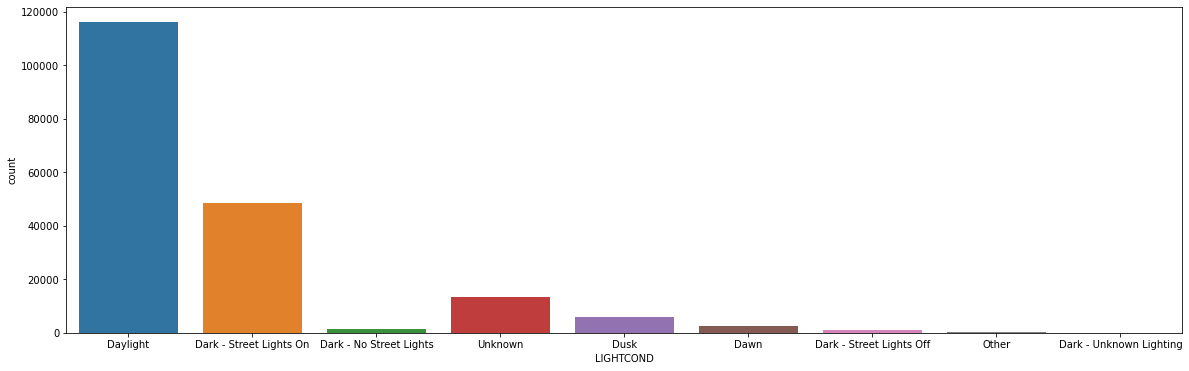

In [625]:
plt.figure(figsize=(20,6))
sns.countplot(df['LIGHTCOND'])

There are seven light conditions in the dataset. The majority conditions are the "Daylight" and "Dark - Street Lights on" light conditions.

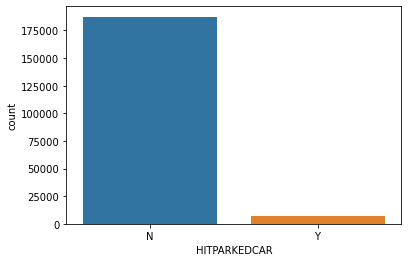

In [626]:
sns.countplot(df['HITPARKEDCAR'])

The majority of the collisions didn't involve hitting a parked car.

### Data Preprocessing 

Replacing missing values in "ADDRTYPE" column with the mode of the column: "Block"

In [627]:
df['ADDRTYPE'].fillna(df['ADDRTYPE'].mode()[0],inplace=True)
print(df['ADDRTYPE'].mode()[0])

Block


Replacing missing values in "COLLISIONTYPE" colum with the mode of the column: "Parked Car"

In [628]:
df['COLLISIONTYPE'].fillna(df['COLLISIONTYPE'].mode()[0],inplace=True)
print(df['COLLISIONTYPE'].mode()[0])

Parked Car


Replacing missing values in "INATTENTIONIND" colum with "N" and then mapping the Y to 1 and N to 0.
The mojortiy of the collisions aren't due to inattention.

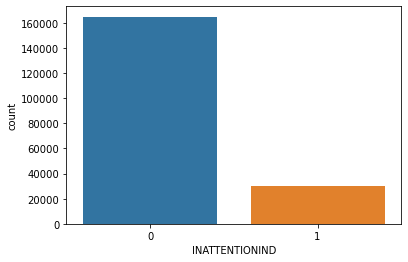

In [629]:
df['INATTENTIONIND'].fillna('N',inplace=True)
df['INATTENTIONIND']=df['INATTENTIONIND'].replace({'Y':1,'N':0})
sns.countplot(df['INATTENTIONIND'])

Mapping the Y to 1 and N to 0. Replacing missing values in "UNDERINFL" colum with the mode of the column: N (0). The majority of collisions weren't under the influence of drugs or alcoohol.

0


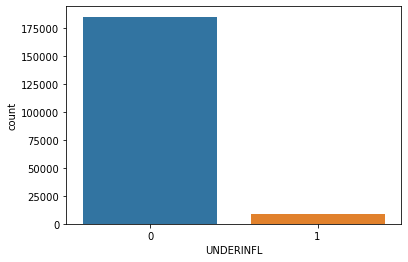

In [640]:
df['UNDERINFL']=df['UNDERINFL'].replace({'Y':'1','N':'0'})
df['UNDERINFL'].fillna(df['UNDERINFL'].mode()[0],inplace=True)
print(df['UNDERINFL'].mode()[0])
sns.countplot(df['UNDERINFL'])

Merging the "Unknown" and "Other" classes together in the "Other" class in "WEATHER" column. Then replacing the missing values with the mode of the column: "Clear"

Clear


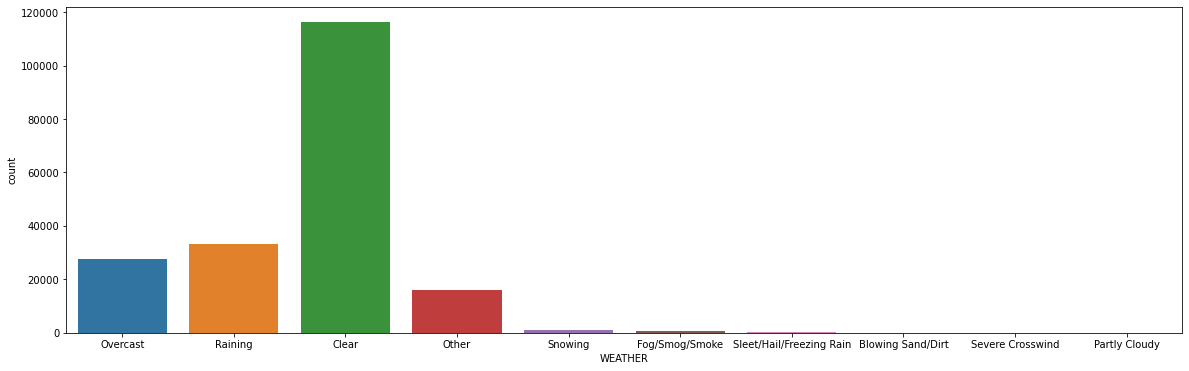

In [668]:
df['WEATHER'].replace({'Unknown':'Other'},inplace=True)
df['WEATHER'].fillna(df['WEATHER'].mode()[0],inplace=True)
print(df['WEATHER'].mode()[0])
plt.figure(figsize=(20,6))
sns.countplot(df['WEATHER'])

Merging the "Unknown" with the "Other" class, the "Standing Water" with the "Wet" class and the "Snow/Slush" with the "Ice" class in "ROADCOND" column. Then replacing the missing values with the mode of the column: "Dry"

Dry


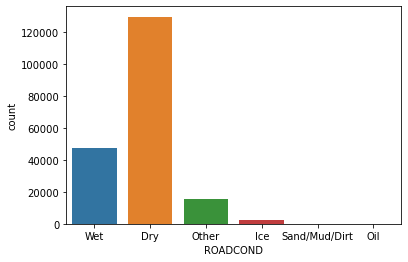

In [631]:
df['ROADCOND'].replace({'Standing Water':'Wet','Snow/Slush':'Ice','Unknown':'Other'},inplace=True)
df['ROADCOND'].fillna(df['ROADCOND'].mode()[0],inplace=True)
print(df['ROADCOND'].mode()[0])
sns.countplot(df['ROADCOND'])

Merging the "Dark - Street Lights On","Dark - No Street Lights","Dark - Street Lights Off","Dark - Unknown Lighting" classes with the "Dark" class and the "Unknown" class with the "Other" class in "LIGHTCOND" column. Then replacing the missing values with the mode of the column: "Daylight"

Daylight


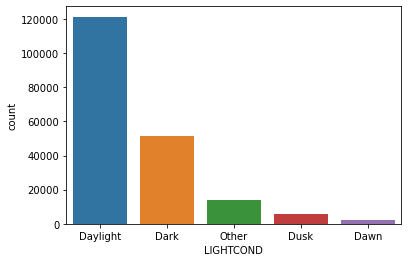

In [632]:
df['LIGHTCOND'].replace({'Dark - Street Lights On':'Dark','Dark - No Street Lights':'Dark',
                    'Dark - Street Lights Off':'Dark','Dark - Unknown Lighting':'Dark','Unknown':'Other'},inplace=True)
df['LIGHTCOND'].fillna(df['LIGHTCOND'].mode()[0],inplace=True)
print(df['LIGHTCOND'].mode()[0])
sns.countplot(df['LIGHTCOND'])

Replacing the missing values in the "PEDROWNOTGRNT" column with "N", then mapping the Y to 1 and N to 0.
In the majority of the collisions the pedestrian right of way was not granted.

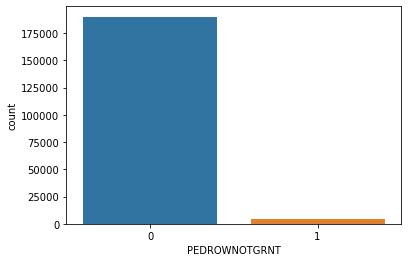

In [633]:
df['PEDROWNOTGRNT'].fillna('N',inplace=True)
df['PEDROWNOTGRNT'].replace({'Y':'1','N':'0'},inplace=True)
sns.countplot(df['PEDROWNOTGRNT'])

Replacing the missing values in the "SPEEDING" column with "N", then mapping the Y to 1 and N to 0. In the majority of the collisions speeding was not a factor in the collision.

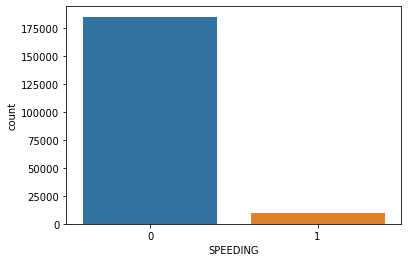

In [634]:
df['SPEEDING'].fillna('N',inplace=True)
df['SPEEDING'].replace({'Y':'1','N':'0'},inplace=True)
sns.countplot(df['SPEEDING'])

Mapping the values in the "HITPARKEDCAR" column the Y to 1 and N to 0. 

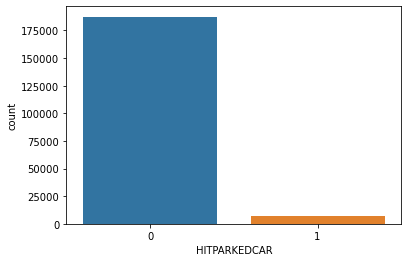

In [635]:
df['HITPARKEDCAR'].replace({'Y':'1','N':'0'},inplace=True)
sns.countplot(df['HITPARKEDCAR'])

#### One hot encoding for categorical variables and dropping the first column to avoid collinearity

In [636]:
df=pd.get_dummies(df,columns=['ADDRTYPE','COLLISIONTYPE','WEATHER','ROADCOND','LIGHTCOND'],drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 40 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   SEVERITYCODE                      194673 non-null  int64 
 1   PERSONCOUNT                       194673 non-null  int64 
 2   PEDCOUNT                          194673 non-null  int64 
 3   PEDCYLCOUNT                       194673 non-null  int64 
 4   VEHCOUNT                          194673 non-null  int64 
 5   INATTENTIONIND                    194673 non-null  int64 
 6   UNDERINFL                         189789 non-null  object
 7   PEDROWNOTGRNT                     194673 non-null  object
 8   SPEEDING                          194673 non-null  object
 9   HITPARKEDCAR                      194673 non-null  object
 10  ADDRTYPE_Block                    194673 non-null  uint8 
 11  ADDRTYPE_Intersection             194673 non-null  uint8 
 12  CO

#### Changing data types to integer

In [641]:
df['UNDERINFL']=df['UNDERINFL'].astype(int)
df['PEDROWNOTGRNT']=df['PEDROWNOTGRNT'].astype(int)
df['SPEEDING']=df['SPEEDING'].astype(int)
df['HITPARKEDCAR']=df['HITPARKEDCAR'].astype(int)

In [642]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 40 columns):
 #   Column                            Non-Null Count   Dtype
---  ------                            --------------   -----
 0   SEVERITYCODE                      194673 non-null  int64
 1   PERSONCOUNT                       194673 non-null  int64
 2   PEDCOUNT                          194673 non-null  int64
 3   PEDCYLCOUNT                       194673 non-null  int64
 4   VEHCOUNT                          194673 non-null  int64
 5   INATTENTIONIND                    194673 non-null  int64
 6   UNDERINFL                         194673 non-null  int32
 7   PEDROWNOTGRNT                     194673 non-null  int32
 8   SPEEDING                          194673 non-null  int32
 9   HITPARKEDCAR                      194673 non-null  int32
 10  ADDRTYPE_Block                    194673 non-null  uint8
 11  ADDRTYPE_Intersection             194673 non-null  uint8
 12  COLLISIONTYPE_Cy


### Dealing with Imbalanced data

1) Undersampling majority class

In [643]:
# class count
class_count_1, class_count_2 = df['SEVERITYCODE'].value_counts()

# Separate class
class_1 = df[df['SEVERITYCODE'] == 1]
class_2 = df[df['SEVERITYCODE'] == 2]
print('class 1:', class_1.shape)
print('class 2:', class_2.shape)

class 1: (136485, 40)
class 2: (58188, 40)


In [644]:
class_1_under = class_1.sample(class_count_2)

df_under = pd.concat([class_1_under, class_2], axis=0)

print("total class of 2 and 1:\n",df_under['SEVERITYCODE'].value_counts())

total class of 2 and 1:
 2    58188
1    58188
Name: SEVERITYCODE, dtype: int64


In [645]:
df_under

,SEVERITYCODE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR,...,WEATHER_Unknown,ROADCOND_Ice,ROADCOND_Oil,ROADCOND_Other,ROADCOND_Sand/Mud/Dirt,ROADCOND_Wet,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk,LIGHTCOND_Other
102008,1,2,0,0,2,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
192205,1,4,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15451,1,3,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
92757,1,2,0,0,2,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
171412,1,8,0,0,4,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194663,2,3,0,0,2,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
194666,2,2,0,0,2,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
194668,2,3,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
194670,2,3,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


2) Oversampling the minority class

In [646]:
class_2_over = class_2.sample(class_count_1, replace=True)

df_over = pd.concat([class_2_over, class_1], axis=0)

print("total class of 2 and 1:\n",df_over['SEVERITYCODE'].value_counts())

total class of 2 and 1:
 2    136485
1    136485
Name: SEVERITYCODE, dtype: int64


In [647]:
df_over

,SEVERITYCODE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR,...,WEATHER_Unknown,ROADCOND_Ice,ROADCOND_Oil,ROADCOND_Other,ROADCOND_Sand/Mud/Dirt,ROADCOND_Wet,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk,LIGHTCOND_Other
131508,2,4,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
140884,2,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
47519,2,3,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20972,2,6,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
107251,2,3,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194664,1,8,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
194665,1,2,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
194667,1,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
194669,1,2,0,0,2,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


### Feature selection 

Setting the X and Y variables

In [648]:
X=df.drop('SEVERITYCODE',axis=1)
Y=df[['SEVERITYCODE']]

Fitting random forest for feature selection

In [649]:
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
clf.fit(X, Y)
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)

In [650]:
feat_importances.sort_values(ascending=False)

COLLISIONTYPE_Parked Car            0.148409
PERSONCOUNT                         0.127756
PEDCOUNT                            0.091124
VEHCOUNT                            0.060510
COLLISIONTYPE_Pedestrian            0.060295
COLLISIONTYPE_Cycles                0.059214
PEDCYLCOUNT                         0.052438
COLLISIONTYPE_Rear Ended            0.050025
COLLISIONTYPE_Sideswipe             0.047218
ADDRTYPE_Intersection               0.035995
ADDRTYPE_Block                      0.023379
PEDROWNOTGRNT                       0.020493
LIGHTCOND_Daylight                  0.020470
INATTENTIONIND                      0.018334
ROADCOND_Other                      0.017527
ROADCOND_Wet                        0.016545
SPEEDING                            0.015764
UNDERINFL                           0.015736
COLLISIONTYPE_Other                 0.015708
WEATHER_Unknown                     0.011841
LIGHTCOND_Other                     0.009772
LIGHTCOND_Dusk                      0.009326
WEATHER_Cl

Take features where their importance > 0.01

In [651]:
feat_importances[feat_importances>0.01].index

Index(['PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INATTENTIONIND',
       'UNDERINFL', 'PEDROWNOTGRNT', 'SPEEDING', 'ADDRTYPE_Block',
       'ADDRTYPE_Intersection', 'COLLISIONTYPE_Cycles', 'COLLISIONTYPE_Other',
       'COLLISIONTYPE_Parked Car', 'COLLISIONTYPE_Pedestrian',
       'COLLISIONTYPE_Rear Ended', 'COLLISIONTYPE_Sideswipe',
       'WEATHER_Unknown', 'ROADCOND_Other', 'ROADCOND_Wet',
       'LIGHTCOND_Daylight'],
      dtype='object')

Different Models to try and compare results with:

In [594]:
# model=LogisticRegression(random_state=42)
# model=KNeighborsClassifier(n_neighbors=3)
# model=DecisionTreeClassifier(random_state=42)
model=RandomForestClassifier(random_state=42)

Adjusting the X variables to the final features set

In [599]:
# Using the unbalanced dataframe
X=df[['PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INATTENTIONIND',
       'UNDERINFL', 'PEDROWNOTGRNT', 'SPEEDING', 'ADDRTYPE_Block',
       'ADDRTYPE_Intersection', 'COLLISIONTYPE_Cycles', 'COLLISIONTYPE_Other',
       'COLLISIONTYPE_Parked Car', 'COLLISIONTYPE_Pedestrian',
       'COLLISIONTYPE_Rear Ended', 'COLLISIONTYPE_Sideswipe', 'WEATHER_Other',
       'ROADCOND_Other', 'ROADCOND_Wet', 'LIGHTCOND_Daylight',
       'LIGHTCOND_Other']]
Y=df[['SEVERITYCODE']]


# Using the undersampled dataframe
# X=df_under[['PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INATTENTIONIND',
#        'UNDERINFL', 'PEDROWNOTGRNT', 'SPEEDING', 'ADDRTYPE_Block',
#        'ADDRTYPE_Intersection', 'COLLISIONTYPE_Cycles', 'COLLISIONTYPE_Other',
#        'COLLISIONTYPE_Parked Car', 'COLLISIONTYPE_Pedestrian',
#        'COLLISIONTYPE_Rear Ended', 'COLLISIONTYPE_Sideswipe', 'WEATHER_Other',
#        'ROADCOND_Other', 'ROADCOND_Wet', 'LIGHTCOND_Daylight',
#        'LIGHTCOND_Other']]
# Y=df_under[['SEVERITYCODE']]


# Using the oversampled dataframe
# X=df_over[['PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INATTENTIONIND',
#        'UNDERINFL', 'PEDROWNOTGRNT', 'SPEEDING', 'ADDRTYPE_Block',
#        'ADDRTYPE_Intersection', 'COLLISIONTYPE_Cycles', 'COLLISIONTYPE_Other',
#        'COLLISIONTYPE_Parked Car', 'COLLISIONTYPE_Pedestrian',
#        'COLLISIONTYPE_Rear Ended', 'COLLISIONTYPE_Sideswipe', 'WEATHER_Other',
#        'ROADCOND_Other', 'ROADCOND_Wet', 'LIGHTCOND_Daylight',
#        'LIGHTCOND_Other']]
# Y=df_over[['SEVERITYCODE']]

Splitting data, fitting the model and printing the acuracy score of the model

In [600]:
X_train,X_test,y_train,y_test=train_test_split(X, Y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.702182505585152

Predicting test values, and calculating the AUC score

In [601]:
y_pred=model.predict(X_test)
y_scores=model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_scores)

0.7828696167902449

Printing the classification report

In [602]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.76      0.61      0.67     11795
           2       0.67      0.80      0.73     11481

    accuracy                           0.70     23276
   macro avg       0.71      0.70      0.70     23276
weighted avg       0.71      0.70      0.70     23276



Grid Search for the best model: Random Forest for undersampled

In [603]:
X=df_under[['PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INATTENTIONIND',
       'UNDERINFL', 'PEDROWNOTGRNT', 'SPEEDING', 'ADDRTYPE_Block',
       'ADDRTYPE_Intersection', 'COLLISIONTYPE_Cycles', 'COLLISIONTYPE_Other',
       'COLLISIONTYPE_Parked Car', 'COLLISIONTYPE_Pedestrian',
       'COLLISIONTYPE_Rear Ended', 'COLLISIONTYPE_Sideswipe', 'WEATHER_Other',
       'ROADCOND_Other', 'ROADCOND_Wet', 'LIGHTCOND_Daylight',
       'LIGHTCOND_Other']]
Y=df_under[['SEVERITYCODE']]


In [604]:
rfc=RandomForestClassifier(random_state=42)
X_train,X_test,y_train,y_test=train_test_split(X, Y, test_size=0.2, random_state=42)

In [605]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [606]:
from sklearn.model_selection import GridSearchCV
# CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
# CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [607]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 500}

### Final Model fitting

In [609]:
rf=RandomForestClassifier(criterion= 'gini', max_depth= 8, max_features= 'auto', n_estimators= 500)

In [610]:
X_train,X_test,y_train,y_test=train_test_split(X, Y, test_size=0.2, random_state=42)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.7044595291287162

In [611]:
y_pred=rf.predict(X_test)
y_scores=rf.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_scores)

0.7876767923589701

In [612]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.75      0.62      0.68     11795
           2       0.67      0.79      0.73     11481

    accuracy                           0.70     23276
   macro avg       0.71      0.71      0.70     23276
weighted avg       0.71      0.70      0.70     23276

